In [46]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

# K channels: inactivation

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Na channel recordings in the "data/Na_channels" folder

In [47]:
data_folder = "data/K_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/K_channels


['data/K_channels/2024_06_08_0007.abf',
 'data/K_channels/2024_06_08_0013.abf',
 'data/K_channels/2024_06_08_0014.abf']

Choose which file you want to analyze and past the file name here:

In [48]:
# data_file = 'data/K_channels/2024_06_08_0007.abf'
# data_file = 'data/K_channels/2024_06_08_0014.abf'

data_file = 'data/K_channels/example/K_deact_3.5.abf'


Now we can load the file and plot the raw data:

Data dimensions (sweeps, channels, timepoints): 
(11, 2, 28500)
sampling freq: 49999.99999999999 Hz


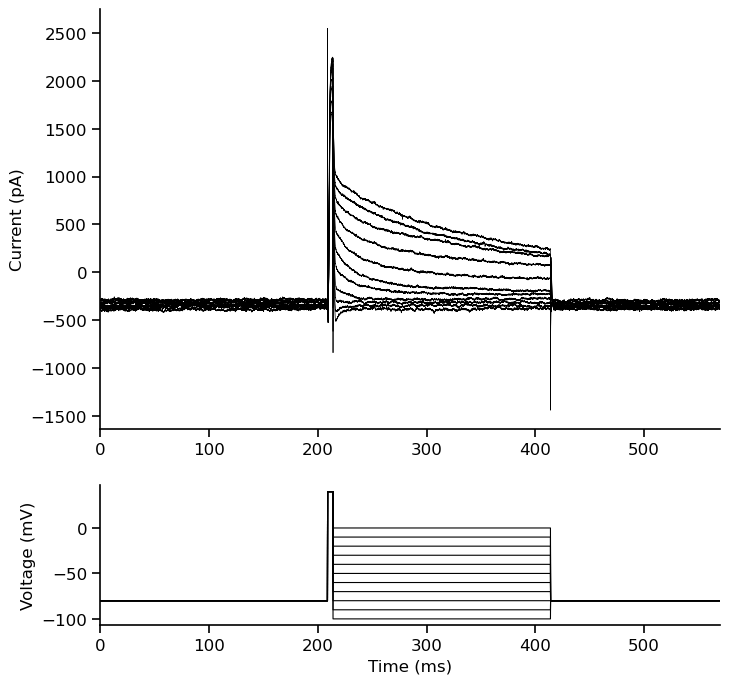

In [49]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(f"Data dimensions (sweeps, channels, timepoints): \n{sweeps.shape}")
print(f"sampling freq: {sampling_freq} Hz")

current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
ax = plot_traces(sweeps_time, current_traces, voltage_traces)
plt.show()

## 2. Select what you want to measure

### 2.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

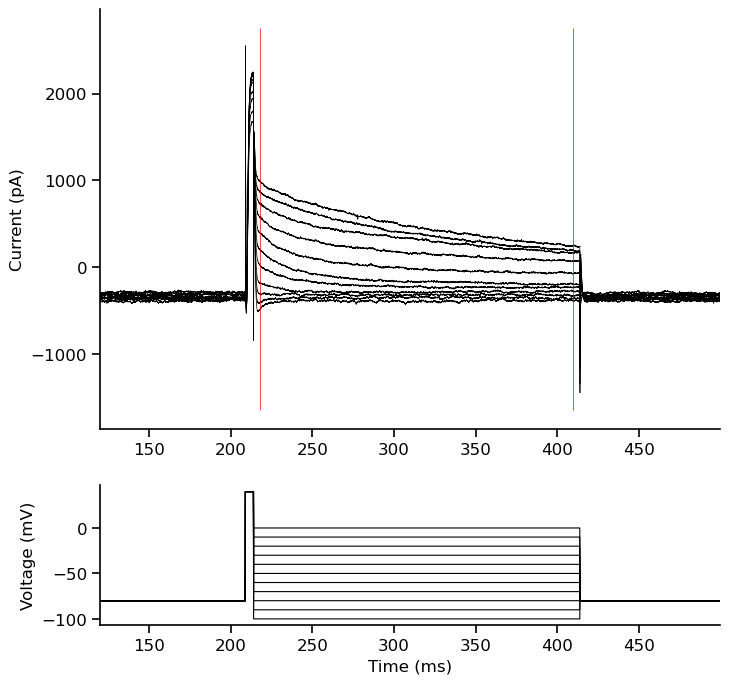

In [58]:
# The start/end time just helps to zoom in on the traces.
start_time = 120  # milliseconds
end_time = 500   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 218  # milliseconds
marker_2 = 410    # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

### 3.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [59]:
# Measure baseline: you need to specify which part of the trace you want to use for baseline measurement.
start_time = 0 # milliseconds
end_time = 50 # milliseconds
measurement_type = 'mean' # Options: 'mean', 'max', 'min'

baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

# Subtract baseline from the sweeps
num_traces = sweeps.shape[0]
for i in range(num_traces):
    sweeps[i,0] -= baseline_current[i]

### 3.2. Measure the instantaneous currents (when channels are open)

Here we will be using the timepoints from the markers we defined above and get the peak currents in that time window.

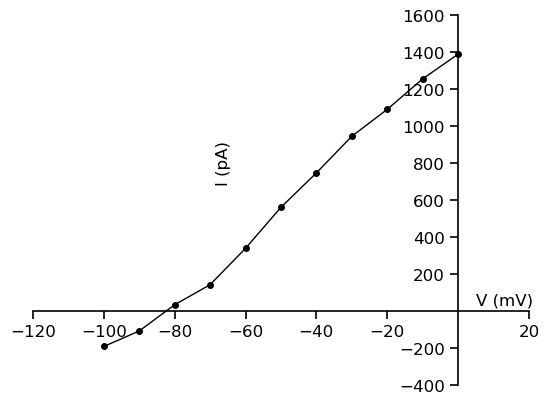

In [60]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

voltage_steps, current_steps = get_step_measurements(sweeps, sweeps_time, 
                                                     start_time=marker_1,
                                                     end_time=marker_2,
                                                     sampling_freq=sampling_freq,
                                                     measurement_type=measurement_type)

ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.25), ylabel_coords=(0.4,0.6))
plt.show()

### 3.3. Optional: fit a line to the I-V points to estimate the reversal potential and conductance

G = slope = 16.865 nS
Resistance = 1/slope = 59.294 MOhm
Reversal potential: -83.475 mV


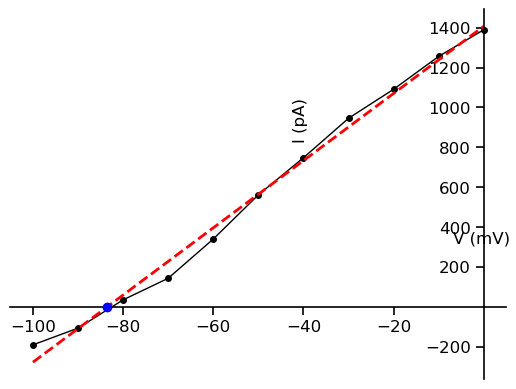

In [61]:
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.4), ylabel_coords=(0.6,0.7))

# Fit a line to the points
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(voltage_steps, current_steps)
ax.plot(voltage_steps, slope * voltage_steps + intercept, linestyle='--', color='r', label='Fit', linewidth=2)

print(f"G = slope = {slope:.3f} nS")
print(f"Resistance = 1/slope = {1/slope * 1000:.3f} MOhm")

# Find the intercept on the x-axis (where current is zero) to get E_Na (reversal potential)
E_Na = -intercept / slope
ax.scatter(E_Na, 0, color='b', zorder=5)
print(f"Reversal potential: {E_Na:.3f} mV")

### 3.4. Measure the decay timeconstant of the currents (fit an exponential to the current decay)

In [62]:
# Get the peak value for each trace, and fit the exponential from the start to the peak
current_between_markers, time_between_markers = select_sweep_window(sweeps, sweeps_time, marker_1, marker_2, sampling_freq, channel=0)
voltage_between_markers, time_between_markers = select_sweep_window(sweeps, sweeps_time, marker_1, marker_2, sampling_freq, channel=1)

# If there are any traces we want to exclude, we can do that here:
# (e.g. exclude traces where we can't get a good measurement of tau)
traces_to_exclude = []

trace_idx = np.array([i for i in range(len(current_between_markers)) if i not in traces_to_exclude])
current_between_markers = current_between_markers[trace_idx]
voltage_between_markers = voltage_between_markers[trace_idx]

/var/folders/q9/g15z8pxs2fd8tgyd9ggfv1c8x5w4qx/T/ipykernel_99223/1113492526.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_params,_ = curve_fit(exponential_curve, time_ms, trace, p0=[V0_guess, tau_guess, Vinf_guess], maxfev=10000)


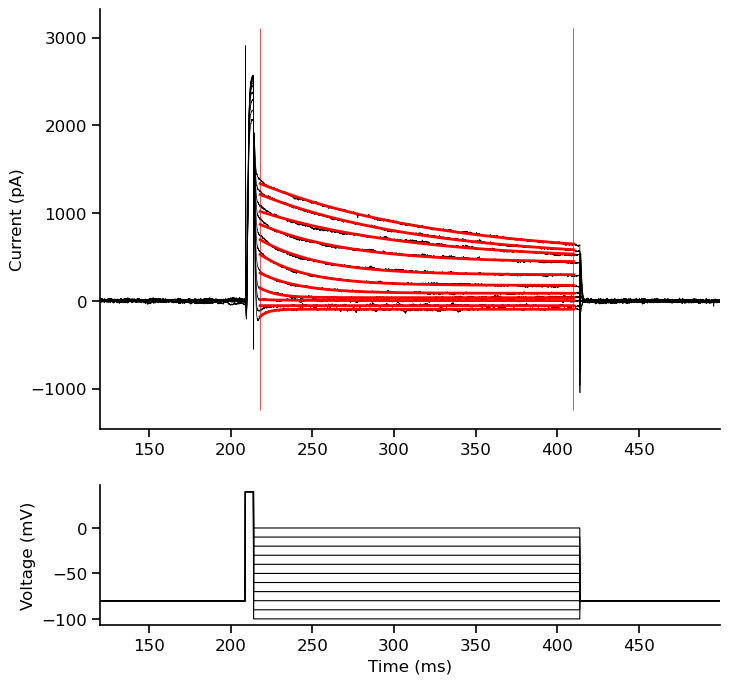

In [63]:
# We need an initial guess for fitting the exponential curve
# (if the fit doesn't work, try to change this value))
tau_guess = 100 # milliseconds

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)

def exponential_curve(time, V0, tau, V_inf):
    return V0 * np.exp(-time / tau) + V_inf

tau_values = []
for trace in current_between_markers:
    time_ms = time_between_markers * 1000
    V0_guess = trace[0]
    Vinf_guess = trace[-1]
    try:
        fit_params,_ = curve_fit(exponential_curve, time_ms, trace, p0=[V0_guess, tau_guess, Vinf_guess], maxfev=10000)
        V0_fit, tau_fit, Vinf_fit = fit_params
        tau_values.append(tau_fit)

        # Overlay fit
        fit_trace = exponential_curve(time_ms, *fit_params)
        ax[0].plot(time_ms, fit_trace, color='r', alpha=1, linewidth=2)
    except RuntimeError:
        print("Error fitting trace")
        tau_values.append(np.nan)
        continue

    if tau_values[-1] > 1000:
        tau_values[-1] = np.nan
plt.show()


Finally, let's plot the the decay timeconstant vs the voltage steps applied.

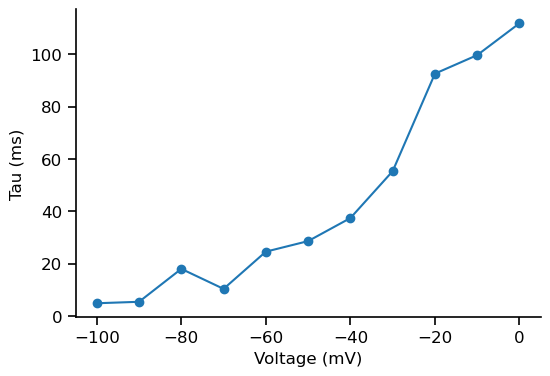

In [64]:
voltage_steps = voltage_between_markers[:, 0]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(voltage_steps, tau_values, 'o-')
ax.set_ylabel('Tau (ms)')
ax.set_xlabel('Voltage (mV)')
plt.show()